# Import datas

In [8]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
import numpy as np

digits = load_digits()
X = digits['data']
Y = digits['target']

#enc = OneHotEncoder()
#Y = enc.fit_transform(Y.reshape(-1, 1))

X.shape, Y.shape

((1797, 64), (1797,))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1257, 64), (540, 64), (1257,), (540,))

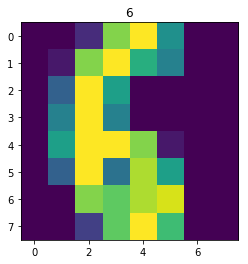

In [10]:
import matplotlib.pyplot as plt
i = np.random.choice(range(len(X_train)))
plt.imshow(X_train[i].reshape(8,8))
plt.title(Y_train[i])
plt.show()

# Define PyTorch model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_features):
        super(Model, self).__init__()
        self.dense1 = nn.Linear(n_features, 32).double()
        self.relu1 = nn.ReLU().double()
        self.dense2 = nn.Linear(32, 10).double()
        self.history = {}
        
    def forward(self, x, training):
        out = x
        out = self.dense1(out)
        out = self.relu1(out)
        out = F.dropout(out, p=0.1, training=training)
        out = self.dense2(out)
        return out
    
    def fit(self, X, Y, epochs, batch_size, validation_data=None):
        
        Loss = nn.CrossEntropyLoss(reduction='mean')
        
        def Accuracy(x,y):
            return (x.argmax(dim=1)==y).sum().float()/len(x)
        
        
        input = torch.tensor(X, requires_grad=True, dtype=torch.double)
        target = torch.tensor(Y, dtype=torch.long)
        
        if not validation_data is None:
            val_input = torch.tensor(validation_data[0], dtype=torch.double)
            val_target = torch.tensor(validation_data[1], dtype=torch.long)
        
        self.history['loss'] = []
        self.history['acc'] = []
        if not validation_data is None: self.history['val_loss'] = []
        if not validation_data is None: self.history['val_acc'] = []
    
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
        #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        n_batch = np.ceil(len(X)/batch_size)
        indices = np.arange(len(X))
        for i in range(epochs):
            np.random.shuffle(indices)
            batches = np.array_split(indices, n_batch)
            for b in batches:
                out = self.forward(input[b], training=True)
                loss = Loss(out, target[b])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            out = self.forward(input, training=False)
            loss = Loss(out, target)
            acc = Accuracy(out, target)
            self.history['loss'].append(loss.data.numpy())
            self.history['acc'].append(acc)
            if not validation_data is None:
                val_out = self.forward(val_input, training=False)
                val_loss = Loss(val_out, val_target)
                val_acc = Accuracy(val_out, val_target)
                self.history['val_loss'].append(val_loss.data.numpy())
                self.history['val_acc'].append(val_acc)
                
    def predict(self, x):
        input = torch.tensor(x, requires_grad=False, dtype=torch.double)
        input = self.forward(input, training=False)
        input = F.softmax(input, dim=1)
        return input.data.numpy()
                
def init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-1, 1)
        m.bias.data.zero_()
                
model = Model(n_features=64)
model.apply(init)

print(model)

Model(
  (dense1): Linear(in_features=64, out_features=32, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=32, out_features=10, bias=True)
)


# Train Model

In [13]:
model.fit(X_train, Y_train,
          epochs=500,
          batch_size=128,
          validation_data=(X_test, Y_test)
         )
hist = model.history

# Results

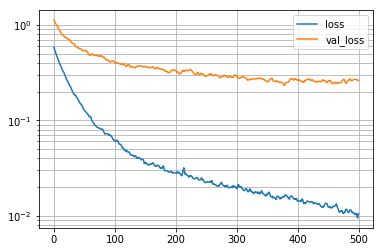

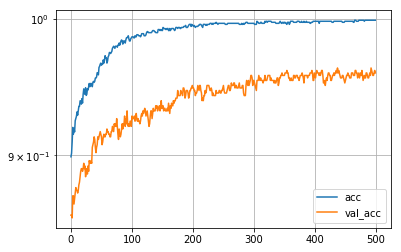

In [14]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.show()

plt.plot(hist['acc'], label='acc')
plt.plot(hist['val_acc'], label='val_acc')
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.show()